<a href="https://colab.research.google.com/github/Harshita-2205/Single-shot-detection/blob/main/ssd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision ssd


In [2]:
import kagglehub
path = kagglehub.dataset_download("vijayabhaskar96/pascal-voc-2007-and-2012")

print("Path to dataset files:", path)

100%|██████████| 2.64G/2.64G [00:34<00:00, 81.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vijayabhaskar96/pascal-voc-2007-and-2012/versions/1


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torchvision.models import VGG16_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class SSD(nn.Module):
    def __init__(self, num_classes):
        super(SSD, self).__init__()
        self.num_classes = num_classes

        # Load the pre-trained VGG16 model
        vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
        self.features = nn.ModuleList(vgg[:30])  # Use up to the conv5_3 layer

        # Additional layers for SSD
        self.extras = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(512, 1024, kernel_size=3, padding=1, dilation=1),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(512, 128, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 256, kernel_size=3),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 256, kernel_size=3),
                nn.ReLU(inplace=True)
            )
        ])

        # Localization and class prediction layers
        self.loc = nn.ModuleList([
            nn.Conv2d(512, 4 * 4, kernel_size=3, padding=1),  # 4 default boxes
            nn.Conv2d(1024, 6 * 4, kernel_size=3, padding=1),  # 6 default boxes
            nn.Conv2d(512, 6 * 4, kernel_size=3, padding=1),  # 6 default boxes
            nn.Conv2d(256, 6 * 4, kernel_size=3, padding=1),  # 6 default boxes
            nn.Conv2d(256, 4 * 4, kernel_size=3, padding=1),  # 4 default boxes
            nn.Conv2d(256, 4 * 4, kernel_size=3, padding=1)   # 4 default boxes
        ])

        self.conf = nn.ModuleList([
            nn.Conv2d(512, 4 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(1024, 6 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(512, 6 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, 6 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, 4 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, 4 * num_classes, kernel_size=3, padding=1)
        ])

    def forward(self, x):
        locs = []
        confs = []

        # Apply base network
        for k in range(len(self.features)):
            x = self.features[k](x)

        # Apply localization and confidence layers on conv4_3 and conv7
        locs.append(self.loc[0](x).permute(0, 2, 3, 1).contiguous())
        confs.append(self.conf[0](x).permute(0, 2, 3, 1).contiguous())

        for (i, layer) in enumerate(self.extras):
            x = layer(x)
            locs.append(self.loc[i+1](x).permute(0, 2, 3, 1).contiguous())
            confs.append(self.conf[i+1](x).permute(0, 2, 3, 1).contiguous())

        # Reshape and concatenate predictions
        locs = torch.cat([o.view(o.size(0), -1) for o in locs], 1)
        confs = torch.cat([o.view(o.size(0), -1) for o in confs], 1)

        locs = locs.view(locs.size(0), -1, 4)
        confs = confs.view(confs.size(0), -1, self.num_classes)

        return locs, confs

# Data Transformations for SSD Input
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
def my_collate(batch):
    """
    Custom collate function to handle varying number of bounding boxes.
    """
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Pad the bounding boxes to have the same size
    max_num_boxes = max(len(t['annotation']['object']) for t in targets)

    for t in targets:
        num_boxes = len(t['annotation']['object'])

        # Padding with zeros for boxes and labels
        padding = max_num_boxes - num_boxes

        # Reshape if the padding is greater than 0
        if padding > 0:
            # Pad bounding boxes
            padding_boxes = [[0, 0, 0, 0]] * padding
            t['annotation']['object'].extend(padding_boxes)

    return torch.stack(images), targets


# Load Pascal VOC Dataset
def load_data():
    voc_dataset = datasets.VOCDetection(
        root='./data', year='2012', image_set='trainval', download=True, transform=transform
    )
    dataloader = DataLoader(voc_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=my_collate) # Use custom collate function
    return dataloader


In [6]:
def display_sample(image, boxes):
    """ Display image with bounding boxes for visualization."""
    # Ensure the image is in numpy format and in the correct range for OpenCV
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
        image = np.clip(image * 255, 0, 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

    # Convert to BGR color format before drawing rectangles
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Draw bounding boxes
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)

    # Convert back to RGB for display with matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 75.4MB/s]


100%|██████████| 2.00G/2.00G [00:59<00:00, 33.6MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


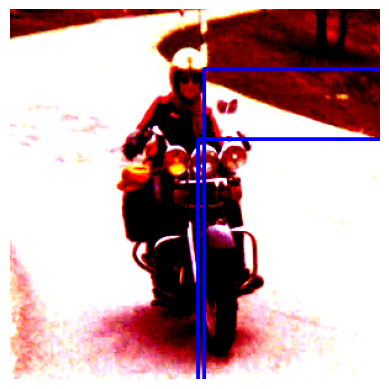

In [9]:
if __name__ == "__main__":
    num_classes = 21  # 20 classes + background
    ssd = SSD(num_classes)
    data_loader = load_data()

    for i, (images, targets) in enumerate(data_loader):
        if i == 1:
            break  # Visualize only the first batch for demonstration

        # Display the first image and its bounding boxes
        img = images[0].permute(1, 2, 0).numpy()  # Convert to (H, W, C) format for display

        # Handle both single and multiple object cases
        objects = targets[0]['annotation']['object']
        if isinstance(objects, dict):  # Single object case
            objects = [objects]  # Convert to list format

        # Extract bounding boxes, only processing items that are dictionaries
        boxes = [
            [
                float(obj['bndbox']['xmin']), float(obj['bndbox']['ymin']),
                float(obj['bndbox']['xmax']), float(obj['bndbox']['ymax'])
            ]
            for obj in objects if isinstance(obj, dict)  # Ignore padded entries
        ]

        # Display the image with bounding boxes
        display_sample(img, boxes)

In [10]:
print(objects)

[{'name': 'motorbike', 'bndbox': {'xmax': '336', 'xmin': '152', 'ymax': '420', 'ymin': '105'}, 'difficult': '0', 'occluded': '1', 'pose': 'Frontal', 'truncated': '0'}, {'name': 'person', 'bndbox': {'xmax': '345', 'xmin': '157', 'ymax': '351', 'ymin': '48'}, 'difficult': '0', 'occluded': '1', 'pose': 'Frontal', 'truncated': '0'}]
